# Assignment 2

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2022/wiki/Assignment-1-and-2) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday, March the 28th, 2022 at 23:59. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Monday, April the 4th, 2022 at 23:59.

**Contributions**: In class I told you we will use DTU Learn. But Sune came up with a nicer idea!! **I'll send you a secret id by email later today** so you can add the contributions directly at the end of the notebook. They should look somewhat like this:

* id1: did this, this, and this
* id2: did that, that, and that
* id3: ...

**N.B.** It is NOT OK to say that each member contributed equally!

This Assignment is based on the last three weeks of the course (Week 6-8). Before going on please load the data with the following line. In this way, you won't need to submit anything else than the .ipynb file and we will be able to run your notebook!

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree

In [2]:
column_list = ["age", "sex", "race", "juv_fel_count", "juv_misd_count", "juv_other_count",
               "priors_count", "two_year_recid", "days_b_screening_arrest"]

df = pd.read_csv("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/recidivism_dataset_sub.csv", usecols=column_list)

## Part 1: Predicting criminal recidivism

The following exercises are a subset of the ones we did during Week 6. If you have doubts or need more help, go back to the Week 6 notebook. There, you will find additional hints to complete the assignment.

> *Exercise 1:* Build a Decision Tree or a Random Forest. 
>   * Preprocess the data by only keeping records that have between $-30$ and $30$ days between the arrest and screening, then drop the `days_b_screening_arrest` column for the upcoming analysis.
>   * Some features we are working with are categorical, so we need to deal with them by using encoders. There are many different types, but we will focus on the `OneHotEncoder` and the `LabelEncoder`:
>      * Which encoder did you choose? Describe what it does and why you chose it.
>   * Split the data in Train/Test sets by using a 70/30 split and `random_state=42`.
>   * Fit a model to your Train set. Choose between a `DecisionTreeClassifier` or a `RandomForestClassifier`. 
>      * Describe how the model you chose works and why you chose it.
>   * Evaluate the performance of model on the test set, i.e compute Accuracy, Precision, and Recall. 
>      * What are your thoughts on these metrics? Is accuracy a good measure?
>   * Are your results tied to the specific hyperparameter set you used? Perform a `RandomizedSearchCV` and recompute the performance metric above with the hyperparameters found. What do you observe?
>   * Visualize the tree. There are different options to do so. You can have a look at Week 6 for hints on how to do it. What do you observe?

## Part 1: Solution

In [3]:
filtered = df[abs(df.days_b_screening_arrest) <= 30].drop('days_b_screening_arrest', axis=1)

> When using label encoding the `race` column is going to be ranked based on the alphabetical order of the original values. This is dangerous because the model might capture a hierarchy between the values while in reality they aren't really ordinal variables. To avoid this we are using the One-Hot encoding. Even though One-Hot encoding can lead to a problem where the variables are highly correlated to each other, we will stick to it, and handle the issue of multicolinearity later on. We are encoding `race` and `sex`.

In [4]:
encoder = OneHotEncoder(handle_unknown='ignore')

# encoding race
encoded = encoder.fit_transform(filtered.race.values.reshape(-1,1)).toarray()
race_encoded = pd.DataFrame(encoded, columns=["race_" + str(i + 1) for i in range(encoded.shape[1])])
X = pd.concat([filtered, race_encoded], axis=1).drop('race', axis=1)

# encoding sex
encoded = encoder.fit_transform(filtered.sex.values.reshape(-1,1)).toarray()
sex_encoded = pd.DataFrame(encoded, columns=["is_female", "is_male"])
X = pd.concat([X, sex_encoded], axis=1).drop(["sex", "is_female"], axis=1)

X.dropna(inplace=True)

> Since the encoded sex columns are trivially correlated, we are dropping one of them. But things aren't so for the encoded race columns. One of the things we can do there is calculate Variance Inflation Factor (VIF) which tells us how much molticollinearity the columns present. If VIF > 5 then we need to drop some of the columns. REF: https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/

In [5]:
vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
x_var_names = race_encoded.columns

for i in range(0, x_var_names.shape[0]):
    y = race_encoded[x_var_names[i]]
    x = race_encoded[x_var_names.drop([x_var_names[i]])]
    r_squared = sm.OLS(y,x).fit().rsquared
    vif = round(1/(1-r_squared),2)
    vif_df.loc[i] = [x_var_names[i], vif]

vif_df

,Var,Vif
0,race_1,1.0
1,race_2,1.0
2,race_3,1.0
3,race_4,1.0
4,race_5,1.0
5,race_6,1.0


> Since VIF = 1 for all of the columns, there isn't an issue with multicollinearity, so we can proceed without dropping any of the columns. The exercise didn't specify the target, so we are sticking to the original one mentioned in Week 6, which is `two_year_recid`

In [6]:
y = X['two_year_recid']
X.drop('two_year_recid', axis=1, inplace=True)

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

> Our choice of classification model landed upon the `RandomForestClassifier` as it tends to yield better results on datasets than simple decision trees. This is simply due to the fact that it uses more trees. The only drawback is the amount of computation necessary to use the method, but since the dataset is rather small, we can overlook this fact.

> To understand what a random forest is, first we have to understand what a decision tree is. A decision tree is a supervised learning method that can be used to solve classification (and regression) tasks. The way it solves the problem is by learning simple decision rules from the data features. Decision rules are as simple as asking whether a number is greater or lower than 1. The difficult question is which questions to ask, and the best question is the one that separates the data best. This can be measured using different techniques like entropy or impurity gain. A random forest takes decision trees as its building blocks constructs them and draws conclusions by interpreting the individual results and putting the together by majority voting (or taking the average if it is a regression task). The term "random" in random forests means that each decision tree in the forest considers a random subset of the features when formulating the questions and can only access a random set of the training data, thus increasing diversity and lowering the chance of overfitting. REF: https://williamkoehrsen.medium.com/random-forest-simple-explanation-377895a60d2d and https://towardsdatascience.com/how-are-decision-trees-built-a8e5af57ce8

In [7]:
classifier = RandomForestClassifier(n_estimators = 1000, random_state = 42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
errors = abs(y_pred - y_test)
error_rate = len(errors[errors == 1]) / len(y_pred)
print('Error rate: ' + str(error_rate))

Error rate: 0.3619167717528373


> The baseline for error rate metric could be set to 50% in binary classification problems with no prior background knowledge, as that is the percentage of classes you will get right if you guess randomly on a balanced dataset in terms of labels. As we can see the error rate for our model is around 36% percent so the accuracy is 64%. One might think that having high accuracy is good, but this metric is heavily influenced by the unbalancedness of a dataset in terms of classes we want to predict. In our case it's slightly tilted to the not recid class:

In [8]:
print('Not recid:' + str(len(y[y == 0])))
print('Recid:' + str(len(y[y == 1])))

Not recid:2888
Recid:2398


>If we want a more clear picture, we also have to observe other metrics, such as precision, recall, f1 score...

In [9]:
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 score: ' + str(f1_score(y_test, y_pred)))

Accuracy: 0.6380832282471627
Precision: 0.5962373371924746
Recall: 0.5827439886845828
F1 score: 0.5894134477825465


> We can now see that our model performed slightly better than the baseline. We could improve the model by using leave-one-out cross validation, or `RandomizedSearchCV`, to tune our hyperparameters. REF: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

classifier_random = RandomizedSearchCV(estimator=classifier, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
classifier_random.fit(X_train, y_train)

> And now we can evaluate the performance of our model again, and observe that while the accuracy hasn't really improved all that well, the precision got better but the recall got worse, and it all adds up to the overall f1 score to be 1% better. Hyperparameter tuning seems to have had a minor improvment effect overall.

In [11]:
y_pred = classifier_random.predict(X_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 score: ' + str(f1_score(y_test, y_pred)))

Accuracy: 0.667717528373266
Precision: 0.6446945337620579
Recall: 0.5671852899575672
F1 score: 0.6034612490594432


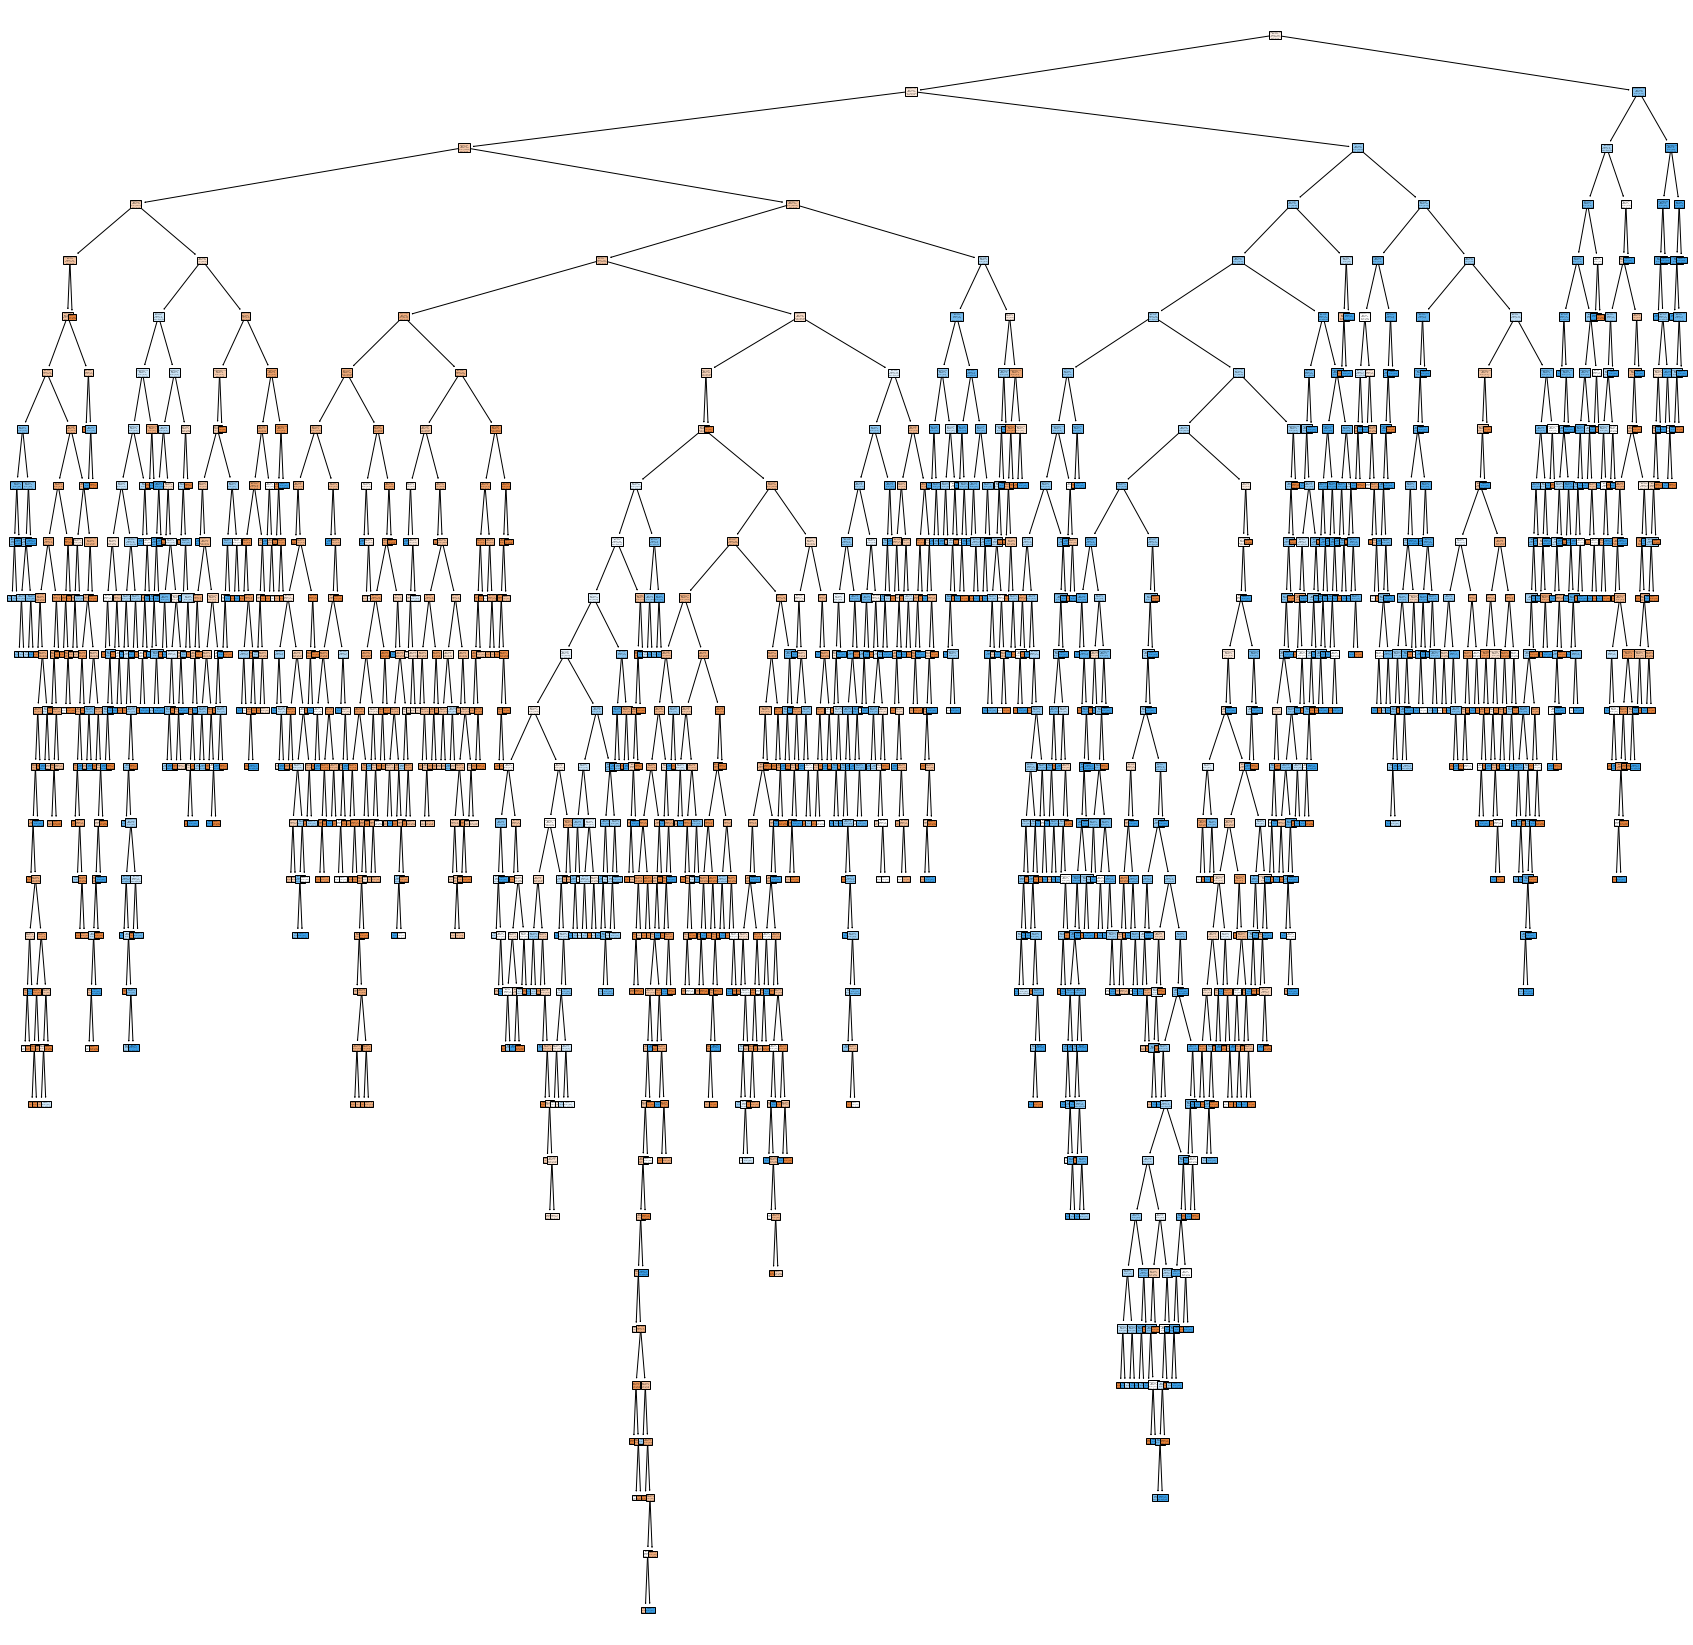

In [12]:
# Visualizing the tree
plt.figure(figsize=(30,30))
_ = tree.plot_tree(classifier.estimators_[0], feature_names=list(X.columns), class_names=['is_recid', 'is_not_recid'], filled=True)

> The tree is way too complex to be easily visualized.

Before going on. Assign the predictions on the test set of your best model to the `y_hat` variable, and their related probabilities to the `y_prob` variable. Remember to use: `y_prob = model.predict_proba(X_test)`

**N.B.** Set a specific `random_state` in your model too. Otherwise if we rerun your results we might not be able to reproduce them!

In [52]:
y_hat = y_pred
y_prob = classifier_random.predict_proba(X_test)

## Part 2: Fairness and bias in Machine Learning

We already know the model you've built is biased. In the next exercises we are going to apply a debiasing method. Please, refer to Week 7, Part 3 for more hints on how to solve these exercises. But first a couple of questions about bias.

>*Exercise 2.1:* A few questions about bias.
> * What are the most common types of data bias? 
> * What are the potential bias sources/types in our case-study (i.e. recidivism)?

> *Exercise 2.2:* Equal Odds. We are going to use `y_prob` to debias the ML model for African-Americans and Caucasians.
>
>    * Define the thresholds as `ths = np.linspace(1e-5,1-1e-5, 10)` and create a function that given a threshold `th` and `y_prob` returns `y_hat` as:
>
>$$\begin{cases}\hat{y}=1, \mbox{ if } y_{prob} > th \\ \hat{y}=0, \mbox{ otherwhise}\end{cases}    \mbox(1)$$ 
>
>
>   * To find the two thresholds that correct for the bias for African-Americans and Caucasians, you can either compute the distance of the ROC curve points or visually find the thresholds (as described in Week 7 Ex. 3.3).
>      * Describe the method you have used to find the thresholds (i.e. Visual or Computational) and how you used it to identify the thresholds. What thresholds did you find? 
>   * Debias the model output by re-computing $\hat{y}$ with the thresholds you found. 
>      * **Hint 1** This means that you have to take `y_prob` of your model African-Americans and apply Eq. (1) with the threshold for African-Americans, and then repeat with the different threshold for Caucasians.
>      * **Hint 2** You shouldn't rerun your model!
>   * Now plot the confusion matrices for African-Americans and Caucasian after you debiased the method. What do you observe? What do you think the problem with this debiasing method is (Refer to Week 7 for more hints)?

## Part 2: Solution

> *Exercise 2.1*:
>   * **Response bias**: it occurs in contents generated by humans (ie. reviews, posts, articles), the source of the data is from a limited subset of the population. The majority of users represent only a few groups.
>   * **Selection bias due to feedback loops**: it occurs when a model influences the generation of data that is used to train it. The model creates this feedback loop by, for example, directing the user attention to a small subset of items then recording their action on said items for later use. This is a problem because the set of items is a non-random subset of the items.
>   * **Bias due to system drift**: it occurs when the system generating the data goes through changes as time goes on. The bias can either come in the form of concept drift (when the definiton of target changes) or model drift (changes in the way a user interacts with the system).
>   * **Omitted variable bias**: occurs when critical attributes that influence the outcome are missing. This can happen with data that was generated by humans, where they weren't allowed to record some information, or when the variable that was omitted correlated with the target or one or more predictor variables.
>   * **Societal bias**: occurs in content produced by humans. The data inherently contains bias and stereotypes and thus the models trained on these types of data will discriminate on race, gender etc.

> The types of biases that might be observable in our case-study are:
>   * **Omitted variable bias**: There might have been recorded variables omitted because they were not meant for public use. 
>   * **Societal bias**: The information on the defendants are literally produced by humans and this type of dataset discriminates highly on race and gender. We would need a way larger dataset for us to be able to come to meaningful conclusions on race and gender.

> REF: https://www.youtube.com/watch?v=tcz800ZXclA

> *Exercise 2.2*:

In [50]:
def is_above_threshold(y_prob, th):
    return [1 if val > th else 0 for val in y_prob[:, 1]]

def calc_TPR_and_FPR(y, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y[i] == y_hat[i] == 1:
           TP += 1
        if y_hat[i] == 1 and y[i] != y_hat[i]:
           FP += 1
        if y[i] == y_hat[i] == 0:
           TN += 1
        if y_hat[i] == 0 and y[i] != y_hat[i]:
           FN += 1

    return (TP / (TP+FN), FP / (FP + TN))

#This function takes as an input y, y_probs, thr 
#and returns the points to plot the ROC curve and their threshold
def roc_curve(y, y_probs, ths):
    #initialize roc as an empty np.array
    roc = np.array([])
    #loop over thresholds
    for th in ths:
      #convert y_prob in y_hat
      y_hat = is_above_threshold(y_probs, th)
      #compute TPR and FPR
      TPR, FPR = calc_TPR_and_FPR(y, y_hat)
      #add threshold and point to roc array
      roc = np.append(roc, [th, FPR, TPR])
    #return roc
    return roc.reshape(-1, 3)

def closest_points(points1, points2):
    #initialize result
    res = list()
    #loop over points in group 1
    for pi in points1:
      #loop over points in group 2
      for pj in points2:
        #add points and their distance to res
        res.append(((pi, pj), np.linalg.norm(pi[1:] - pj[1:])))
    #return sorted result
    return sorted(res, key = lambda x: x[1])

ths = np.linspace(1e-5,1-1e-5, 10)
roc = roc_curve(list(y_test), y_prob, ths)
roc

array([[1.00000000e-05, 1.00000000e+00, 1.00000000e+00],
       [1.11118889e-01, 1.00000000e+00, 1.00000000e+00],
       [2.22227778e-01, 9.30602958e-01, 9.81612447e-01],
       [3.33336667e-01, 5.01706485e-01, 8.04809052e-01],
       [4.44445556e-01, 3.02616610e-01, 6.33663366e-01],
       [5.55554444e-01, 2.00227531e-01, 5.06364922e-01],
       [6.66663333e-01, 9.89761092e-02, 3.26732673e-01],
       [7.77772222e-01, 1.25142207e-02, 9.90099010e-02],
       [8.88881111e-01, 0.00000000e+00, 1.41442716e-03],
       [9.99990000e-01, 0.00000000e+00, 0.00000000e+00]])

## Part 3: Communicate your story and results to others

> *Exercise 3* Fill the article below with the title, subtitles, sections, visualizations and references!
> 
>    * **Note 1** Please, have a look at Week 8 for instructions on how to complete the article and make the visualizations.
>    * **Note 2** Make sure **you add the code** that generate your visualizations! This is really important.
>    * **Note 3** You should have all the necessary inputs to make the visualizations from the exercises in Part 1 and Part 2.

# ADD YOUR TITLE HERE

**Introduction.** Write your introduction here. Think about the audience. This is an article for the general public, so you should try to make it engaging, relatable, not too technical etc.

In [15]:
#First viz here: (Week 8 Visualization 1) Interactive visualization with Bokeh

**Results from exploratory data analysis.** Write this section here. The aim is to show that the data is biased, which might have an impact on the model. Relate this part to the first visualization.

In [16]:
#Second viz here: (Week 8 Visualization 2) plot with 3 subplots (Feature importances, Confusion Matrix, Percentage difference)

**Results from the classification task.** Write this section here. The aim is to show that the model is biased as it is learning from biased data. Relate this part to the second visualization.

In [17]:
#Third viz here: (Week 8 Visualization 3) plot with 2 subplots (ROC curve and selected threshold, TPR and FPR before and after debiasing)

**Results from debiasing method.** Write this section here. The aim is to show that there are methods that can help to enhance fairness in cases as this one. Relate this part to the third visualization.

**Limitations and conclusions.** Write this part here. These are your main take aways, the end of your story, where you should also highlight possible implications/limitations of what you presented.

**References.** Any article need good sources! Whenever you make a statement, refer to data sources, previous studies, methods, etc. add a reference. 

1. reference 1
2. reference 2
3. reference 3
4. etc.

**Assignment Contributions**:

* id1
* id2
* id3